In [1]:
from __future__ import print_function
import pickle 
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

%matplotlib inline

In [80]:
A = np.ones((3, 4))

In [81]:
b = np.ones(4)

In [82]:
A

array([[ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.]])

In [83]:
b

array([ 1.,  1.,  1.,  1.])

In [84]:
A + b

array([[ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.],
       [ 2.,  2.,  2.,  2.]])

In [78]:
A + b

RuntimeError: inconsistent tensor size at /Users/soumith/anaconda/conda-bld/pytorch-0.1.8_1486027042839/work/torch/lib/TH/generic/THTensorMath.c:601

## Load Data

In [2]:
use_cuda = False
momentum_par = 0.5
lr = 0.01
log_interval = 10
epochs = 500

In [3]:
loader_kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [4]:
torch.manual_seed(42)

In [5]:
trainset_labeled = pickle.load(open("data/train_labeled.p", "rb"))

Files already downloaded
3000
750


In [6]:
validset = pickle.load(open("data/validation.p", "rb"))

In [7]:
train_loader = torch.utils.data.DataLoader(trainset_labeled, batch_size=64, shuffle=True, **loader_kwargs)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=True)

## Network

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        return F.log_softmax(x)

In [9]:
model = Net()

if use_cuda:
    model.cuda()

## Optimizer

In [10]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum_par)

## Training

In [11]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

## Testing

In [12]:
def test(epoch, valid_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(valid_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))

In [13]:
for epoch in range(1, epochs + 1):
    train(epoch)
    test(epoch, valid_loader)

Train Epoch: 1 [0/3000 (0%)]	Loss: 2.299089
Train Epoch: 1 [640/3000 (21%)]	Loss: 2.287868
Train Epoch: 1 [1280/3000 (43%)]	Loss: 2.297804
Train Epoch: 1 [1920/3000 (64%)]	Loss: 2.294657
Train Epoch: 1 [2560/3000 (85%)]	Loss: 2.312828

Test set: Average loss: 2.2745, Accuracy: 2731/10000 (27%)

Train Epoch: 2 [0/3000 (0%)]	Loss: 2.295248
Train Epoch: 2 [640/3000 (21%)]	Loss: 2.292928
Train Epoch: 2 [1280/3000 (43%)]	Loss: 2.273643
Train Epoch: 2 [1920/3000 (64%)]	Loss: 2.223941
Train Epoch: 2 [2560/3000 (85%)]	Loss: 2.260562

Test set: Average loss: 2.2152, Accuracy: 3900/10000 (39%)

Train Epoch: 3 [0/3000 (0%)]	Loss: 2.230175
Train Epoch: 3 [640/3000 (21%)]	Loss: 2.228118
Train Epoch: 3 [1280/3000 (43%)]	Loss: 2.249061
Train Epoch: 3 [1920/3000 (64%)]	Loss: 2.250877
Train Epoch: 3 [2560/3000 (85%)]	Loss: 2.228348

Test set: Average loss: 2.0300, Accuracy: 4676/10000 (47%)

Train Epoch: 4 [0/3000 (0%)]	Loss: 2.055495
Train Epoch: 4 [640/3000 (21%)]	Loss: 2.049053
Train Epoch: 4 [1280/

KeyboardInterrupt: 

## Analyzing predictions

In [15]:
model.eval()
test_loss = 0
correct = 0
for data, target in valid_loader:
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    output = model(data)
    test_loss += F.nll_loss(output, target).data[0]
    pred = output.data.max(1)[1] # get the index of the max log-probability
    correct += pred.eq(target.data).cpu().sum()

In [16]:
test_loss /= len(valid_loader) # loss function already averages over batch size

In [17]:
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))


Test set: Average loss: 0.1939, Accuracy: 9438/10000 (94%)



In [18]:
correct

9438

In [20]:
len(valid_loader.dataset) - correct

562

## Code for visualizing incorrectly classified images

In [184]:
model.eval()
test_loss = 0
correct = 0

i = 0
i_limit = 1

# Pixel information for incorrectly classified images
incorrect_pixels = []
# Predictions made by network for incorrectly classified images
incorrect_preds = []
# Actual labels for incorrectly classified images
incorrect_outputs = []

for data, target in valid_loader:
    if i == i_limit:
        break
    i += 1
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    data, target = Variable(data, volatile=True), Variable(target)
    output = model(data)
    test_loss += F.nll_loss(output, target).data[0]
    
    pred = output.data.max(1)[1] # get the index of the max log-probability
    mask = (pred != target.data)
    incorrect_preds += list(pred[mask])
    incorrect_outputs += list(target.data[mask].numpy())
    incorrect_pixels += list(data.data.numpy()[target.data[mask].numpy()])
    correct += pred.eq(target.data).cpu().sum()
    
incorrect_pixels = [torch.FloatTensor(x) for x in incorrect_pixels]

In [185]:
def imshow(img):
    if type(img) == torch.FloatTensor:
        npimg = img.numpy()
    else:
        npimg = img
    plt.imshow(np.transpose(npimg, (1, 2, 0))[:,:,0], 
               cmap='gray')

Images


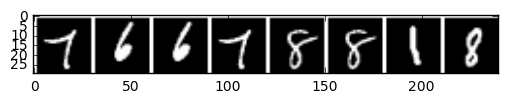

In [186]:
print("Images")
imshow(torchvision.utils.make_grid(incorrect_pixels))

In [187]:
print("Predicted labels:", incorrect_preds)

Predicted labels: [4, 4, 1, 7, 2, 5, 6, 7]


In [188]:
print("Actual labels:", incorrect_outputs)

Actual labels: [9, 8, 8, 9, 3, 3, 1, 2]
